In [100]:
import os
from langgraph.graph import StateGraph, START, END
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from operator import add

## Note that our workflow is more oriented on X social media plateform
* and it will give us optimise tweet on that given topic
* and try to be generated it by funny and original

## so we should have three llm 
1. generator_llm
2. evaluator_llm
3. optimizer_llm

* and each llm should be do their task great;; like generator_llm should be good in writing things great
* i mean we should use diff llms which do great in their fields

* in my case , i will use same llm (lack of resources)

In [110]:
# llm= HuggingFaceEndpoint(
#   repo_id="mistralai/Mistral-7B-Instruct-v0.2",
#   task="chat-completions",
#   huggingfacehub_api_token=os.getenv("HUGGINGFACEHUB_API_TOKEN")
# )

# model= ChatHuggingFace(llm=llm)

model= ChatOpenAI(model= "gpt-4o-mini")



# now try to define the state of langGraph
class PostState(TypedDict):
  topic:str
  tweet:str 
  evaluation_status: Literal["approved", "needs_improvement"] # will be tell us , it is approved or need inprovement 
  evaluation_feedback: str 
  iteration: int # for knowing how many roop have been ron bw evalator and optimizer
  max_iteration: int # bz there is posibility that, this roop have been run infinitly;; so we can brack the roop at this situation

  tweet_history:Annotated[list[str], add]
  feedBack_history:Annotated[list[str], add]


def generate_tweet(state:PostState):
  # steps
  #1. build a prompt
  messages= [
    SystemMessage(content="You are a funny and clever Twitter/X influencer."),
    HumanMessage(content=f"""
Write a short, original, and hilariour tweet on the topic "{state['topic']}". 

Rules:
- DO NOT use question-answer format.
- Max 200 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english.""")
  ]

  prompt= ChatPromptTemplate.from_messages(messages)
  
  #2. tell llm to generate tweet on that given topic
  global model

  parser= StrOutputParser()

  chain= prompt|model|parser

  response= chain.invoke({})


  # return their response
  return {"tweet":response, "tweet_history":[response]}


def evaluate_tweet(state:PostState):

  class EvaluationResoult(BaseModel):
    evaluation: Literal["approved", "needs_improvement"]= Field(description="Evaluate the tweet and tell us, is it following all evaluation criteria or not.")
    feedback:str=Field(description="Give a fair feedback about that tweet on the basis of evaluation criteria")

  # parser= PydanticOutputParser(pydantic_object=EvaluationResoult)

  prompt=[
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f""" 
Evaluate the following tweet:

Topic: "{state['topic']}"
Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

""")
  ]
  global model 

  str_model= model.with_structured_output(EvaluationResoult)

  response= str_model.invoke(prompt)


  return {"evaluation_status":response.evaluation, "evaluation_feedback":response.feedback , "feedBack_history":[response.feedback]}




def optimise_tweet(state:PostState):
  # here we basically tell to improve the tweet in the basis of given feedback
  messages=[
    SystemMessage(content="You punch up tweet for virality and humor based on given feedback."),
    HumanMessage(content=f""" 
Improve the tweet on this feedback: 
"{state['evaluation_feedback']}" 

Topic: "{state['topic']}"
Original Tweet:
"{state['tweet']}"

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
  ]

  prompt= ChatPromptTemplate.from_messages(messages)

  global model

  parser= StrOutputParser() 

  chain= prompt|model | parser 

  response= chain.invoke({})

  return {"tweet":response, "iteration":state.get('iteration', 0)+1, "tweet_history":[response]}




  


In [111]:
## we have to create a condition function for that condition edge which will decide have we been approved ?

def check_approve(state:PostState)-> Literal["approved", "need_improvement"]:
  # let max_iteration=5
  if state.get("max_iteration", 0)>5: 
    return "approved"
  else:
    if state["evaluation_status"]=="approved":
      return "approved"
    else:
      return "need_improvement"  



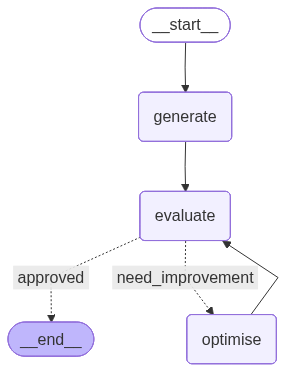

In [112]:
graph= StateGraph(PostState)

graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimise", optimise_tweet)


graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges("evaluate", check_approve, {"approved":END, "need_improvement":"optimise"}) # kind of (from which node you want to take condition edge, function which will decide about next node , on the basis of condition fn result at which node you want to shift)


# and loop always come between two node like here ;; evaluate and optimise
graph.add_edge("optimise", "evaluate")


workflow= graph.compile()
workflow

In [113]:
initial_state={"topic":"Ai is bubble"}
final_state= workflow.invoke(initial_state)

final_state

{'topic': 'Ai is bubble',
 'tweet': 'AI is like that friend who says they’re super into fitness but pops up at all-you-can-eat buffets. Sure, it looks good on paper, but deep down, it’s just a big ol’ bubble! 🍔💻💨',
 'evaluation_status': 'approved',
 'evaluation_feedback': 'This tweet offers a fresh take on the concept of AI being a bubble, using an amusing analogy about a fitness friend at a buffet, making it relatable. The humor is clever and genuinely brings a smile, combining a twist with familiar imagery. It’s punchy and well within character limits, presenting a format that engages well without feeling like a setup-punchline. The added emojis enhance its appeal, making it shareable and likely to go viral.',
 'tweet_history': ['AI is like that friend who says they’re super into fitness but pops up at all-you-can-eat buffets. Sure, it looks good on paper, but deep down, it’s just a big ol’ bubble! 🍔💻💨'],
 'feedBack_history': ['This tweet offers a fresh take on the concept of AI bein